PyTorch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Implements the DC-GAN paper: https://arxiv.org/pdf/1511.06434.pdf

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
%matplotlib inline
import argparse
import os
import random
import time 

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils import data
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML


# Datasets
from data_loader.celeb_a_faces import CelebAFacesDataLoader
from data_loader.anime_faces import AnimeFacesDataLoader
from data_loader.faces import FacesDataLoader
# Models
from models.gan import DCDiscriminatorNet, DCGeneratorNet
# Metrics
from utils.logger import Logger

seed = 999
#seed = random.randint(1,10000) # use for new results
random.seed(seed)
torch.manual_seed(seed)

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setup dataloader
train_data_set = CelebAFacesDataLoader()
train_data = data.DataLoader(train_data_set, batch_size=batch_size, num_workers=workers, shuffle=True)



Generating 202599 images


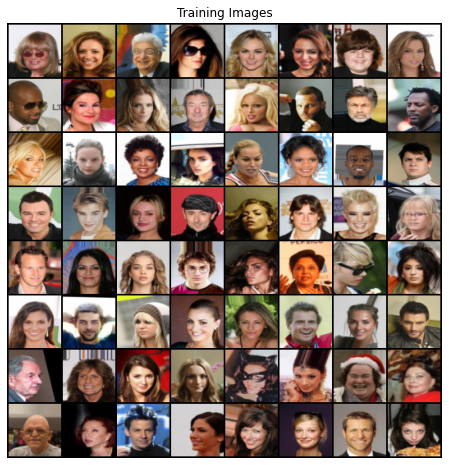

In [2]:
# Plot some training images
real_batch = next(iter(train_data))
plt.figure(figsize=(8,8));
plt.axis("off");
plt.title("Training Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# setup models
netD = DCDiscriminatorNet().to(device)
netD.apply(weights_init)
netG = DCGeneratorNet(nz, filter_dim=512).to(device)
netG.apply(weights_init)


DCDiscriminatorNet(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

DCGeneratorNet(
  (hidden_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden_3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden_4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (out): Sequentia

In [4]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Start training loop")
for epoch in range(num_epochs):
  for i, (data, _) in enumerate(train_data, start=0):
    ## Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    # Train with all-real batch
    netD.zero_grad()
    real_data = data.to(device)
    b_size = real_data.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # forward pass real batch through D
    output = netD(real_data).view(-1)

    # calculate loss on all real batch
    errD_real = criterion(output,label) 

    # calculate gradients for D in backward pass
    errD_real.backward()
    # get the average of the result
    D_x = output.mean().item()
    
    # Train with all-fake batch
    # generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # generate fake image batch with G
    fake_data = netG(noise)
    label = label.fill_(fake_label);
    # classify all fake batch with D
    output = netD(fake_data.detach()).view(-1)
    # calculate D's loss on the all-fake batch
    errD_fake = criterion(output,label) 
    # calculate gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # update D
    optimizerD.step()
    
    ## Update G network: maximize log(D(G(z)))
    netG.zero_grad()
    label = label.fill_(real_label);
    # since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake_data).view(-1)
    # calculate G's loss based on this output
    errG = criterion(output, label)
    # calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # update G
    optimizerG.step()
    
    ## Output training stats
    if i%50 == 0:
      print(f"Epoch: [{epoch}/{num_epochs}][{i}/{len(train_data)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

    # save losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    
    # check how the generator is doing by periodically checking its output on fixed_noise
    if (iters%500 == 0) or ((epoch == num_epochs-1) and (i == len(train_data)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
    iters += 1
    


Start training loop
Epoch: [0/5][0/1583] Loss_D: 0.8429 Loss_G: 0.7802 D(x): 0.8620 D(G(z)): 0.4855 / 0.4623
Epoch: [0/5][50/1583] Loss_D: 0.8243 Loss_G: 0.9135 D(x): 0.9475 D(G(z)): 0.5308 / 0.4118
Epoch: [0/5][100/1583] Loss_D: 0.8430 Loss_G: 0.7937 D(x): 0.8774 D(G(z)): 0.4969 / 0.4579
Epoch: [0/5][150/1583] Loss_D: 0.8368 Loss_G: 0.7989 D(x): 0.8867 D(G(z)): 0.5007 / 0.4545
Epoch: [0/5][200/1583] Loss_D: 0.9036 Loss_G: 0.7712 D(x): 0.9261 D(G(z)): 0.5558 / 0.4734
Epoch: [0/5][250/1583] Loss_D: 0.7751 Loss_G: 0.8076 D(x): 0.8741 D(G(z)): 0.4571 / 0.4647
Epoch: [0/5][300/1583] Loss_D: 0.8688 Loss_G: 0.7077 D(x): 0.8604 D(G(z)): 0.5028 / 0.4945
Epoch: [0/5][350/1583] Loss_D: 0.8390 Loss_G: 0.8412 D(x): 0.9029 D(G(z)): 0.5072 / 0.4364
Epoch: [0/5][400/1583] Loss_D: 0.8670 Loss_G: 0.6923 D(x): 0.8541 D(G(z)): 0.4877 / 0.5031


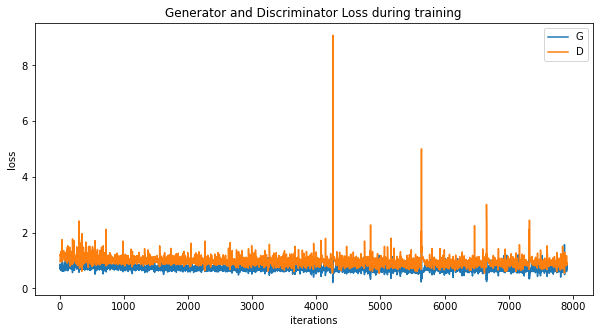

In [46]:
### Results

# visualize training losses
plt.figure(figsize=(10,5));
plt.title("Generator and Discriminator Loss during training");
plt.plot(G_losses, label="G");
plt.plot(D_losses, label="D");
plt.xlabel("iterations");
plt.ylabel("loss");
plt.legend();
plt.show();


Plotting 2 images


(0.0, 1.0, 0.0, 1.0)

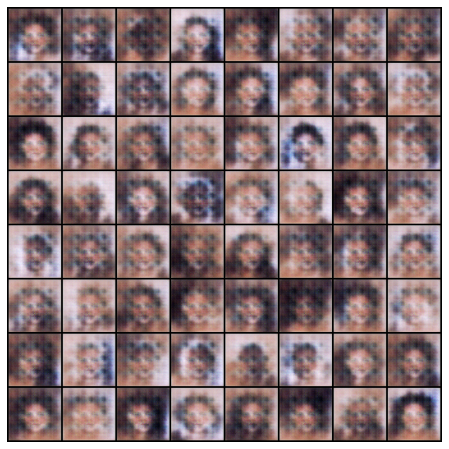

In [39]:
#%%capture
print(f"Plotting {len(img_list)} images")
fig = plt.figure(figsize=(8,8))
plt.axis("off");
imgs = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

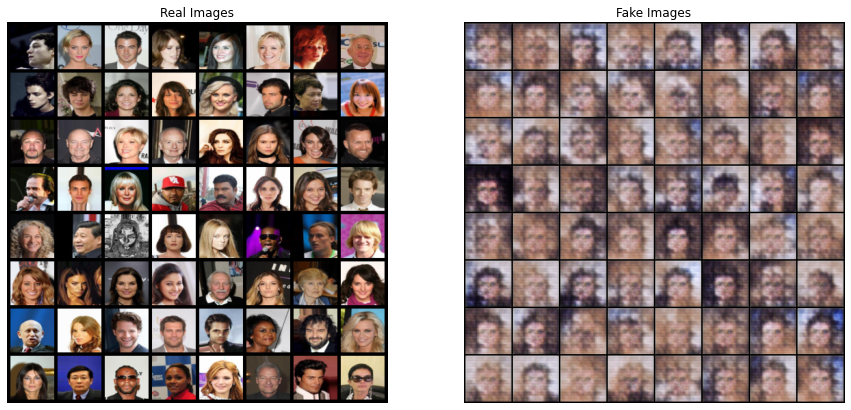

In [44]:
## Plot Real and Fake images side by side
# grab a batch of real images from the dataset
real_batch, _ = next(iter(train_data))

# plot the real images
plt.figure(figsize=(15,15));
plt.subplot(1,2,1);
plt.axis("off");
plt.title("Real Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=5, normalize=True).cpu(), (1,2,0)));

# generate and plot some fake images 
noise = torch.randn(64, nz, 1, 1, device=device)
fake = netG(noise).detach().cpu()
img_grid = vutils.make_grid(fake, padding=2, normalize=True)
plt.subplot(1,2,2);
plt.axis("off");
plt.title("Fake Images");
plt.imshow(np.transpose(img_grid,(1,2,0)));
plt.show();